In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive


/content/drive/MyDrive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

np.random.seed(5)

def price_elast(price, temp, weekday, cost):
    return  -4 + 0.2*price + 0.05*temp + 2*np.isin(weekday, [1,7]) + 0.3 * cost

def sales(price, temp, weekday, cost):
    elast = -abs(price_elast(price, temp, weekday, cost))
    output = np.random.normal(200 + 20*np.isin(weekday, [1,7]) + 1.3 * temp +
                              5*elast * price, 5).astype(int)

    return output


n_rnd = 5000

temp = np.random.normal(24, 4, n_rnd).round(1)
weekday = np.random.choice(list(range(1, 8)), n_rnd)
cost = np.random.choice([0.3, 0.5, 1.0, 1.5], n_rnd)
price_rnd = np.random.choice(list(range(3, 11)), n_rnd)

price_df_rnd = pd.DataFrame(dict(temp=temp, weekday=weekday, cost=cost,
                                 price=price_rnd, sales=sales(price_rnd, temp, weekday, cost)))

n = 10000
temp = np.random.normal(24, 4, n).round(1)
weekday = np.random.choice(list(range(1, 8)), n)
cost = np.random.choice([0.3, 0.5, 1.0, 1.5], n)
price = np.random.normal(5 + cost + np.isin(weekday, [1,7])).round(1)

price_df = pd.DataFrame(dict(temp=temp, weekday=weekday, cost=cost,
                             price=price, sales=sales(price, temp, weekday, cost)))


In [ ]:
price_df_rnd.to_csv("ice_cream_sales_rnd.csv", index=False)
price_df.to_csv("ice_cream_sales.csv", index=False)

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast
import statsmodels.formula.api as smf
from matplotlib import style
style.use("ggplot")

In [6]:
test = pd.read_csv("ice_cream_sales_rnd.csv")
train = pd.read_csv("ice_cream_sales.csv")
train.head()


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


<Axes: xlabel='price', ylabel='sales'>

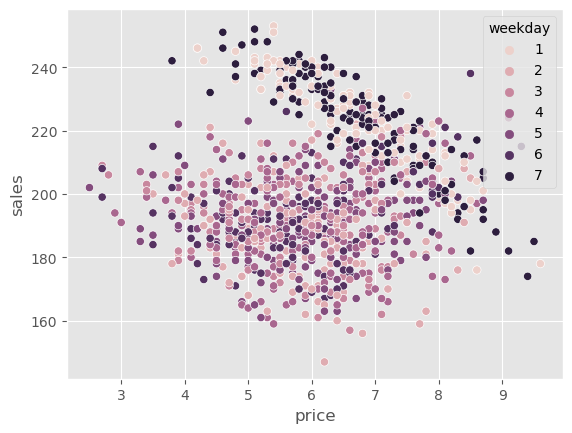

In [ ]:
np.random.seed(123)
sns.scatterplot(data=train.sample(1000), x="price", y="sales", hue="weekday")

Through visualization, it is clear that on the weekend (weekday=1 and 7),

the price is much higher than usual, that is, there is confusion.

In this dataset, feature X includes three variables:

    temperature, cost and day of the week, Treatment T is price, and outcome Y is sales volume.
    
    Where T affects Y and X affects T and Y, there is confusion.

ATE

In [ ]:
my = smf.ols("sales~temp+C(weekday)+cost", data=train).fit()
mt = smf.ols("price~temp+C(weekday)+cost", data=train).fit()

In [ ]:
smf.ols("sales_res~price_res",
        data=train.assign(sales_res=my.resid, # sales residuals
                          price_res=mt.resid) # price residuals
       ).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-5.364e-13,0.111,-4.85e-12,1.000,-0.217,0.217
price_res,-4.0004,0.110,-36.428,0.000,-4.216,-3.785


We’ve estimated the ATE to -4, meaning that each unit increase in price will lower sales by 4 units.

In [7]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_predict

y = "sales"
T = "price"
X = ["temp", "weekday", "cost"]

debias_m = LGBMRegressor(max_depth=3)

train_pred = train.assign(price_res =  train[T] -
                          cross_val_predict(debias_m, train[X], train[T], cv=5)
                          + train[T].mean()) # add mu_t for visualization.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 6.132825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

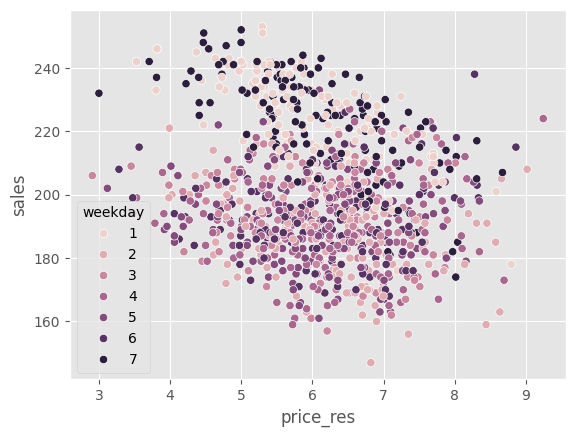

In [8]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales", hue="weekday");

In [9]:
denoise_m = LGBMRegressor(max_depth=3)

train_pred = train_pred.assign(sales_res =  train[y] -
                               cross_val_predict(denoise_m, train[X], train[y], cv=5)
                               + train[y].mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 231
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3
[LightGBM] [Info] Start training from score 200.473000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

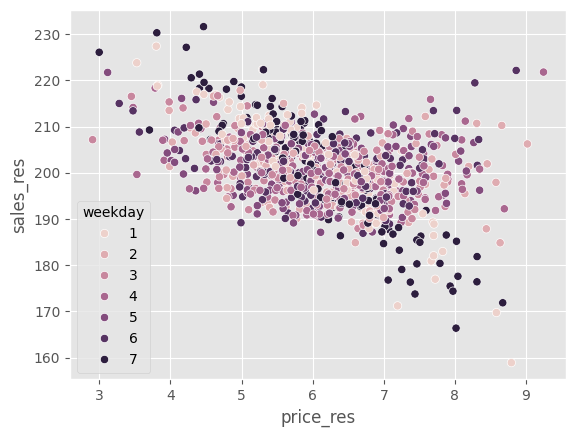

In [10]:
np.random.seed(123)
sns.scatterplot(data=train_pred.sample(1000), x="price_res", y="sales_res", hue="weekday");

In [11]:
final_model = smf.ols(formula='sales_res ~ price_res', data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,224.5586,0.443,506.469,0.000,223.689,225.428
price_res,-3.9228,0.071,-54.962,0.000,-4.063,-3.783


**False anaylsis : without considering cofounding relationship**






In [14]:
final_model = smf.ols(formula='sales ~ price', data=train_pred).fit()
final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,192.9679,1.013,190.414,0.000,190.981,194.954
price,1.2294,0.162,7.575,0.000,0.911,1.547


CATE


In [12]:
final_model_cate = smf.ols(formula='sales_res ~ price_res * (temp + C(weekday) + cost)', data=train_pred).fit()

cate_test = test.assign(cate=final_model_cate.predict(test.assign(price_res=1))
                        - final_model_cate.predict(test.assign(price_res=0)))

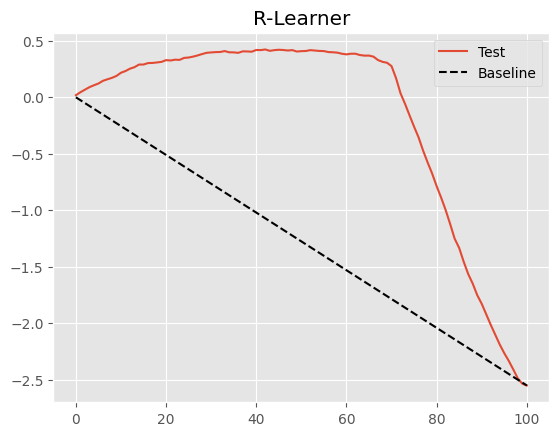

In [13]:
gain_curve_test = cumulative_gain(cate_test, "cate", y=y, t=T)
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot([0, 100], [0, elast(test, y, T)], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("R-Learner");